In [1]:
%env METAL_XCODE=1
%env DISABLE_COMPILER_CACHE=1

env: METAL_XCODE=1
env: DISABLE_COMPILER_CACHE=1


In [12]:
import numpy as np
from open3d import *
import matplotlib.pyplot as plt
from tinygrad import Tensor, dtypes

In [13]:
point_cloud = io.read_point_cloud("../assets/Truck/sparse_pc.ply") # Read point cloud
point_cloud_array = np.asarray(point_cloud.points)
point_cloud_colors = np.asarray(point_cloud.colors)
point_cloud_colors_tinygrad = Tensor(point_cloud_colors, requires_grad=False)

# add one last 0 to the point_cloud array
point_cloud_array_homogeneous = np.hstack((point_cloud_array, np.ones((point_cloud_array.shape[0], 1))))
point_cloud_array_homogeneous_tinygrad = Tensor(point_cloud_array_homogeneous, requires_grad=True, dtype=dtypes.float32)

(3, 4)
(136614, 4)


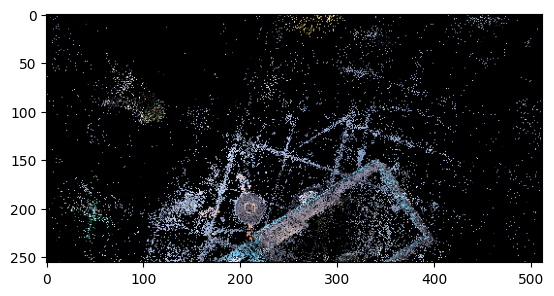

In [18]:
# We follow the convention K = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
# Rt = [[R | t], [0, 0, 0, 1]]
# where the final projection matrix is P = K * Rt

K = Tensor(np.array([[256.0, 0.0, 0], [0.0, 512.0, 0], [0.0, 0.0, 1.0]]), requires_grad=False, dtype=dtypes.float32)
Rt = Tensor(np.array([[-1.0, 0.0, 0.0, -5], 
               [0.0, -1.0, 0.0, -5], 
               [0.0, 0.0, 1.0, -10]]), requires_grad=False, dtype=dtypes.float32)

P = K.dot(Rt)
print(P.shape)
print(point_cloud_array_homogeneous.shape)
point_2d = P.dot(point_cloud_array_homogeneous_tinygrad.transpose()).transpose()
point_2d = point_2d / point_2d[:, 2].reshape(-1, 1)
normalize_0_1 = (point_2d[:, :2]) / K[0,0]
normalize_0_1 = normalize_0_1.numpy()

mask = (normalize_0_1[:, 0] >= 0) & (normalize_0_1[:, 0] <= 1) & (normalize_0_1[:, 1] >= 0) & (normalize_0_1[:, 1] <= 1)
normalize_0_1 = normalize_0_1[mask]
colors = point_cloud_colors[mask]

# plot this points on a 256x256 image
image = np.zeros((256, 512, 3), dtype=np.uint8)

x = (normalize_0_1[:,0] * 511).astype(int)
y = (normalize_0_1[:,1] * 256).astype(int)

image[y, x] = colors[:, :3] * 255

plt.imshow(image)